In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


## The Vanishing/Exploding Gradient Problems

Gradients often get smaller as the algorithm progresses back down to lower layers, leaving them virtually unchanged. This is the #vanishing gradients# problem. 

The opposite of this is the #exploding gradients# problem where the gradients will get larger.

Deep neural networks suffer from unstable gradients generally because different layers learn at different speeds. 

The reason is that there logistic sigmoid function and a certain weight initialization in the early 2000's was part of the reason.

Main reason is that the vairance of the output for each layer is much greater than the variance of the inputs.

### Glorot and He Initialization

Argued that we need the vairance of the outputs of each layer to match its inputs, and the gradients need to have equal variance before and after flowing in the reverse direction.

Not possible to do guarantee both unless layer has equal number of inputs and neurons(called *fan-in* and *fan-out* of the layer).

The Xavier or Glorot Initialization is fan<sub>avg</sub> = (fan<sub>in</sub> + fan<sub>out</sub>) / 2

By default, Keras uses Glorot initialization with uniform distribution.

The He initialization is also a name for ReLu.

Below is a list of initializers:

In [2]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

### Nonsaturating Activation Functions

ReLu is a great choice, but it suffers from *dying ReLu's*, where some neurons only output 0. Huge portions of the network can die, esp. with high learning rates.

To deal with that issue, the made *leaky ReLu* where when its less than zero it becomes negative instead of 0, and it then has a chance of neurons coming back to life.

High leaks seem to do really well. Parametric leaky Relu (PReLu) can be modified through backprop. Its really good for large image datasets but tends to overfit on smaller ones.

Then there is *exponential linear unit* (ELU) that performs better than ReLu. Its main con is that its slower to compute than ReLu and its variants. That it converges faster during training compensates but at test time it will be slower.

*Scaled ELU* (SELU) will self-normalize (if you only use dense layers, and all use SELU), preserving a mean of 0 and std of 1, which solves the gradient problems. It will outperform other activation functions, but it has conditions:
    - Input features must be standardized(mean=0, std=1)
    - Every hidden layer weights must be initialized with LeCun normal initialization. `kernel_initializer="lecun_normal"`
    - Network architecture must be sequential, if used on recurrent networks or networks that are Wide & Deep, self-normalization not guaranteed and performance wont necessairly outperform other functions.
    - Only dense layers, but can improve convolutional neural nets as well.
    

The general path is SELU > ELU > leaky ReLu & variants > ReLu > tanh > logistic.

If network architecure prevents self-normalizing, got to ELU. If I care about runtime latency, leaky Relu (I can set a value for it). Can also cross-validation other unctions, such as RReLu if network is overfitting or PReLu if there is a huge training set. BUT ReLu has a lot of support and is fast.  

### Batch Normalization

The `BatchNormalization` operation goes just before or after a hidden layer. The operatoin zero-centers and normalizes each input, then scales and shifts the result using two new parameter vectors per layer: one for scaling and one for shifting. 

Learns the optimal scale and mean of each layer's inputs.

Most cases, using as a first layer you wont have to use things like `StandardScaler`. It will do the scaling approximately a batch at a time.

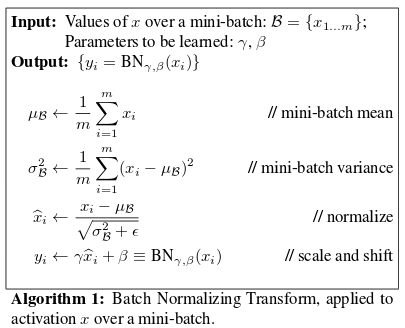


But what about at testing time for predictions? There's no way to calculate each inputs mean and std. One solution would be to wait until the end of training, run the training set through the network and compute the mean and std of each input of the BN layer. These final input means and stds could then be used to make predictions instead of the batch ones. 

But what Keras does is calculate a moving average.
Four parameters are learned in each batch-normalized layer:
The $\gamma$ (output scale vector) and $\beta$ (output offset vector) are learned through backpropagation, $\mu$ (final input mean vector) and $\delta$ (final input standard deviation vector) are estimated using an exponential moving average. $\mu$ and $\delta$ are only used after training.

Pros of Batch Normalization:
- Vanishing gradient problems reduced to the point you can even use saturating activation functions like *tanh* or *logistic*. 
- Less sensitive to weight initialization
- Can use larger learning rates
- Acts like a regularizer
- Can remove the need to standardize input

Cons:
- Slows down predictions due to extra calculations required at runtime

But the con can be negated by fusing the BN layer to the previous one, TFLite's optimizer(Ch19) does this automatically.

In [5]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [6]:
#unlikely for a model this size its going to make a big 
#difference, but its worth it in deep networks
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)               400       
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

The BN layers add 4 * 784 params, this is $\gamma$, $\beta$, $\mu$, and $\delta$. 

The $\mu$ and $\delta$ are the moving final averages, so Keras lists them as non-trainable, adding up all BN layer params and dividing by two gives "Non-trainable params" value.

In [7]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization_3/gamma:0', True),
 ('batch_normalization_3/beta:0', True),
 ('batch_normalization_3/moving_mean:0', False),
 ('batch_normalization_3/moving_variance:0', False)]

In [10]:
# creates two operations that are called per iteration
bn1 = model.layers[1]
bn1.updates

# .updates doesn't seem to work in TF 2.0, prob 
# a new way to see whats below

'''
[<tf.Operation 'cond/Identity' type=Identity>,
 <tf.Operation 'cond_1/Identity' type=Identity>]
'''

"\n[<tf.Operation 'cond/Identity' type=Identity>,\n <tf.Operation 'cond_1/Identity' type=Identity>]\n"

Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a BatchNormalization layer does not need to have bias terms, since the $\beta$ (output offset vector) is included in BN, **it would be a waste of parameters**, so you can set use_bias=False when creating those layers:



In [11]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100,use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

#### Batch Normalization hyperparameters:

Momentum: used when the BN layer updates the exponential moving average. 

v -> v x momentum + v x (1 - momentum)

v is a new vector of input means and std computed from the current batch. Good momemtum values are close to one (0.9, 0.99, 0.999), more 9's for larger datasets and smaller mini-batches.

Axis:

Determines which axis gets normalized. Its default is -1, which means it will normalize the last axis (using the means and standard deviations of the *other* axes).

Looking at the example code above, the first BN layer is 2D (the batch shape is [*batch size, features*]). This means that each of the 784 (28x28) input features will independently normalize based on the mean and std computed across all instances of the batch.

If the BN layer was above the Flatten layer, the inputs become 3D with shape [*batch size, height, width*], the BN will compute 28 means and 28 stds (1 per column of pixels, computed across all instances of the batch and rows of the column), and will normalize all pixels in a given column using the same mean and std. 

**(I need some visualization of the Axis parameter)** 

BatchNormalization is often omitted from diagrams as its assumed to be there after every layer.

A 2019 paper (Hongyi Zhang et al.) used a new weight initialization technique to get state of the art performance without BN.

### Gradient Clipping

Used to hold gradients to a threshold during backprop. Usually used in recurrent neural networks (batch normalization is tricky in RNN's).

In [12]:
# both clipnorm and clipvalue valid
optimizer = keras.optimizers.SGD(clipvalue=1.0)
optimizer = keras.optimizers.SGD(clipnorm=1.0)

This will clip every component of the gradient vector to btw -1.0 and 1.0. It can change the direction of the gradient, which seems like a good thing. 
If you dont want this to happen, using `clipnorm` is better. In the example below it almost eliminates the first component.

`clipvalue` will turn [0.9,100.0] to [0.9,1.0]
`clipnorm` will turn [0.9,100.00] to [0.00899964,0.9999595]

If exploding gradients are observed, best to experiment with both options to see which does best on the validation data.

### Reusing Pretrained layers aka transfer learning

Output layer of old model should usually be replaced because it might not be useful for the task.

The upper layers are less likely to be useful as the lower layer. The high-level features will be differnet between for the new task. 

The more similar the task, the more layers you want to use, starting with lower layers. For very similar tasks, just replace the output layer.

Trying:
Freeze all reused layers first and train. Then try unfreezing one or two of the top layers to see if performance changes.

The more training data, the more layers can unfreeze. Should reduce learning rate so as not to wreck fine-tuned weights.

If still not good and there is little data, drop top hidden layer(s) and refreezing all hidden layers.Keep iterating. If there is a lot of data, you can replace top hidden layers instead of dropping and adding more hidden layers.

### Reusing a Keras model
Let's split the fashion MNIST training set in two:

X_train_A: all images of all items except for sandals and shirts (classes 5 and 6).
X_train_B: a much smaller training set of just the first 200 images of sandals or shirts.
The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using Dense layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [13]:
def split_dataset(X, y):
    # assigning a column with values 5 or 6 for dataset 
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    # dataset A gets all values not 5 or 6
    y_A = y[~y_5_or_6]
    #subtracting 2 from all classes 7,8,9 
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [14]:
X_train_A.shape

(43986, 28, 28)

In [15]:
X_train_B.shape

(200, 28, 28)

In [16]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [17]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [19]:
tf.random.set_seed(42)
np.random.seed(42)

In [20]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28,28]))
for n_hidden in (300,100,50,50,50):
    model_A.add(keras.layers.Dense(n_hidden,activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [24]:
model_A.compile(loss="sparse_categorical_crossentropy",
             optimizer=keras.optimizers.SGD(lr=1e-3),
             metrics=["accuracy"])

In [25]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                     validation_data=(X_valid_A,y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.5926 - accuracy: 0.8104 - val_loss: 0.3896 - val_accuracy: 0.8662
Epoch 2/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3523 - accuracy: 0.8786 - val_loss: 0.3288 - val_accuracy: 0.8827
Epoch 3/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3170 - accuracy: 0.8895 - val_loss: 0.3014 - val_accuracy: 0.8986
Epoch 4/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2973 - accuracy: 0.8975 - val_loss: 0.2896 - val_accuracy: 0.9011
Epoch 5/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2835 - accuracy: 0.9022 - val_loss: 0.2775 - val_accuracy: 0.9061
Epoch 6/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2730 - accuracy: 0.9060 - val_loss: 0.2736 - val_accuracy: 0.9066
Epoch 7/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2641 - accuracy: 0.9092 - val_loss: 0.2718 - val_accuracy:

In [26]:
model_A.save("my_model_A.h5")

In [27]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28,28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [28]:
model_B.compile(loss="binary_crossentropy",
               optimizer=keras.optimizers.SGD(lr=1e-3),
               metrics=["accuracy"])

In [29]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                     validation_data=(X_valid_B,y_valid_B))

Epoch 1/20
7/7 [==============================] - 0s 36ms/step - loss: 0.9573 - accuracy: 0.4650 - val_loss: 0.6314 - val_accuracy: 0.6004
Epoch 2/20
7/7 [==============================] - 0s 18ms/step - loss: 0.5692 - accuracy: 0.7450 - val_loss: 0.4784 - val_accuracy: 0.8529
Epoch 3/20
7/7 [==============================] - 0s 19ms/step - loss: 0.4503 - accuracy: 0.8650 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/20
7/7 [==============================] - 0s 15ms/step - loss: 0.3879 - accuracy: 0.8950 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 15ms/step - loss: 0.3435 - accuracy: 0.9250 - val_loss: 0.3300 - val_accuracy: 0.9320
Epoch 6/20
7/7 [==============================] - 0s 15ms/step - loss: 0.3081 - accuracy: 0.9300 - val_loss: 0.3019 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 14ms/step - loss: 0.2800 - accuracy: 0.9350 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/20
7/7 [===========

In [33]:
#creating a new model with model A's layers
model_A = keras.models.load_model("my_model_A.h5")
# model B on A takes all layers except the last
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
# adding the output layer
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

Doing the above will make model_A and model_B_on_A share the the same layers and if you train one it will affect the other.

To avoid that, *clone* the model with `keras.models.clone_model()`. It does not copy the weights so that will have to be copied as well.

In [34]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

Training the model at this point is not going to go well. The new output layers are weighted randomly and there will be large error gradients that may wreck the reused weights.

One approach to avoid this is to free.e the reused layers for the first few epochs.

Note: always compile model after freezing and unfreezing layers.

In [36]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                    optimizer=keras.optimizers.SGD(lr=1e-3),
                    metrics= ["accuracy"])

In [37]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))
#trained for a few epochs and now unfreezing
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True
#have to compile again
model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 32ms/step - loss: 0.2639 - accuracy: 0.9400 - val_loss: 0.2784 - val_accuracy: 0.9280
Epoch 2/4
7/7 [==============================] - 0s 14ms/step - loss: 0.2543 - accuracy: 0.9400 - val_loss: 0.2689 - val_accuracy: 0.9310
Epoch 3/4
7/7 [==============================] - 0s 14ms/step - loss: 0.2450 - accuracy: 0.9400 - val_loss: 0.2602 - val_accuracy: 0.9341
Epoch 4/4
7/7 [==============================] - 0s 13ms/step - loss: 0.2365 - accuracy: 0.9400 - val_loss: 0.2521 - val_accuracy: 0.9381
Epoch 1/16
7/7 [==============================] - 0s 33ms/step - loss: 0.2117 - accuracy: 0.9500 - val_loss: 0.2040 - val_accuracy: 0.9635
Epoch 2/16
7/7 [==============================] - 0s 22ms/step - loss: 0.1692 - accuracy: 0.9550 - val_loss: 0.1718 - val_accuracy: 0.9716
Epoch 3/16
7/7 [==============================] - 0s 16ms/step - loss: 0.1405 - accuracy: 0.9650 - val_loss: 0.1491 - val_accuracy: 0.9817
Epoch 4/16
7/7 [===============

In [38]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.1408 - accuracy: 0.9705


[0.1408407837152481, 0.9704999923706055]

In [39]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 3ms/step - loss: 0.0563 - accuracy: 0.9940


[0.05627800151705742, 0.9940000176429749]

# Faster Optimizers

### Momentum Optimization

Like a bowling ball down a hill. Will pick up speed until it hits terminal velocity due to friction or air resistance.

Regular gradient descent takes regular steps and can go very slow. Momentum gets to those local minimums faster. High friction set at 0, no friction at 1. Generally set at 0.9.

It will oscillate a little as it reaches a local minimum, which is why some friction is good.


In [40]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

### Nesterov Accelerated Gradient

Looks ahead at the gradient and adjusts the momentum accordingly. It will converge faster due to less oscillations.

In [41]:
optimizer = keras.optimizers.SGD(lr=0.001,
                                 momentum=0.9, nesterov=True)

### AdaGrad

This algorithm decays the learning rate, but does so faster for steep dimensions versus dimensions with gentle slopes. It has an *adaptive learning rate*, which helps it point to the global minimum and it benefits from not requiring much tuning of the learning rate hyperparameter.

However, it is not really good for deep neural networks. The learning rate gets scaled down and stopped before it gets to global minimum. It could be good for things like Linear regression for efficiency.

In [42]:
optimizer = keras.optimizers.Adagrad(lr=0.001)

### RMSProp

This algorithm fixes the issue with AdaGrad by accumulating only recent iterations of the gradients (instead of all iterations)

Set it to 0.9, usually doesn't need to be changed. Was preferred until Adam optimizaiton came around.

In [43]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

### Adam and Nadam Optimization

#### Adam

Stands for *adaptive moment estimation*. It combines momentum optimization and RMSProp. 

`beta_1` is typically set at 0.9, and `beta_2` is usually at 0.999.

The epsilon or smoothing rate is usually 10^-7, which the default is when `epsilon` is None. Can change the default value by `keras.backend.set_epsilon()`.

#### AdaMax 

Can be more stable than Adam, but it depends on the dataset, usually Adam performs better. 

#### Nadam

Add Nesterov gradient trick to Adam so it converges slightly faster. 

----

Adaptive methods like the above are great and converge quickly, but sometimes lead to poor solutions. If results aren't looking good with RMSProp,Adam, or Nadam, try Nesterov Accelerated Gradient.



In [44]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

### Optimization and Derivatives

All the techniques here rely on *first-order partial derivatives* or Jacobians. There are algorithms based on *second-order partial derivatives* or Hessians that
are amazing, but they are also more computationally demanding and *currently* cant fit into memory.

### Note on Training a Sparse Model

The optimizers here produce dense models, most parameters will be nonzero. If I want a super fast model at runtime or one that takes up less memory, a sparse model might be better.

One way to get it is set small weights to zero, but it risk performance degradation and might not even give you a sparse model.

A better way is to apply strong L1 regularization, it will push as many weights to zero as it can.

## Learning Rate Scheduling

The idea behind Learning rate scheduling is that with a constant learning rate, there are issues. Too high and it will diverge, too low and it will converge slowly, even slightly high it will bounce around an optimum. So learning rate scheduling adjusts the lr during trainingto help convergence. 

Types of Learning Rate Scheduling:

### Power Scheduling

lr = lr0 / (1 + steps / s)**c

Schedule drops quickly at first and then slows down more and more after s number of steps. The initial lr0, s, and c are all adjustable hyperparameters. 

In [45]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [48]:
n_epochs = 25
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid))

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5923 - accuracy: 0.7951 - val_loss: 0.4612 - val_accuracy: 0.8426
Epoch 2/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4527 - accuracy: 0.8384 - val_loss: 0.4175 - val_accuracy: 0.8568
Epoch 3/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4223 - accuracy: 0.8489 - val_loss: 0.4808 - val_accuracy: 0.8160
Epoch 4/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4049 - accuracy: 0.8552 - val_loss: 0.3982 - val_accuracy: 0.8618
Epoch 5/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3933 - accuracy: 0.8609 - val_loss: 0.3865 - val_accuracy: 0.8656
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3822 - accuracy: 0.8633 - val_loss: 0.3826 - val_accuracy: 0.8690
Epoch 7/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3748 - accuracy: 0.8672 - val_loss: 0.3779 - val_accuracy:

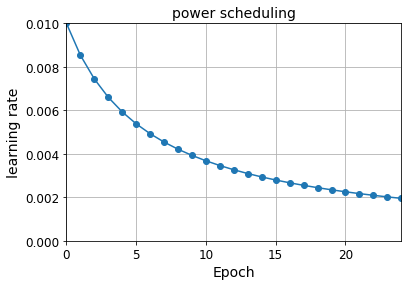

In [49]:
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs,lrs,"o-")
# can set the axis, start & end of x, start & end of y
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("learning rate")
plt.title("power scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling

lr = lr0 * 0.1**(epoch / s)

Learning rate will drop by a factor of 10 every *s* steps. Constant reduction of lr.

In [50]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch/s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [51]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [52]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, epochs=n_epochs,
                   validation_data=(X_valid,y_valid),
                   callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 11s 7ms/step - loss: 0.7334 - accuracy: 0.7594 - val_loss: 0.8768 - val_accuracy: 0.7472
Epoch 2/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.5188 - accuracy: 0.8249 - val_loss: 0.4242 - val_accuracy: 0.8490
Epoch 3/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4505 - accuracy: 0.8470 - val_loss: 0.6683 - val_accuracy: 0.7852
Epoch 4/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4066 - accuracy: 0.8615 - val_loss: 0.3892 - val_accuracy: 0.8714
Epoch 5/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3784 - accuracy: 0.8709 - val_loss: 0.3745 - val_accuracy: 0.8738
Epoch 6/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3532 - accuracy: 0.8791 - val_loss: 0.3966 - val_accuracy: 0.8768
Epoch 7/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3304 - accuracy: 0.8867 - val_loss: 0.4071 - val_ac

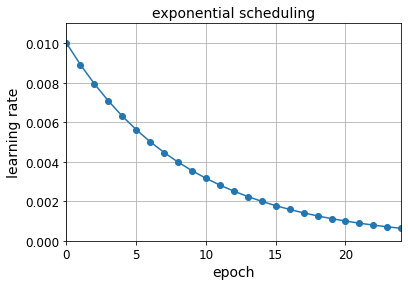

In [53]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0,n_epochs - 1, 0, 0.011])
plt.xlabel("epoch")
plt.ylabel("learning rate")
plt.title("exponential scheduling", fontsize=14)
plt.grid(True)
plt.show()

If instead of at each epoch, I can write my own callback class to change to each batch iteration.

In [54]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 11s 7ms/step - loss: 0.7871 - accuracy: 0.7664 - val_loss: 0.6950 - val_accuracy: 0.7866
Epoch 2/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.6256 - accuracy: 0.8079 - val_loss: 0.5721 - val_accuracy: 0.8186
Epoch 3/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.5699 - accuracy: 0.8223 - val_loss: 0.6324 - val_accuracy: 0.8314
Epoch 4/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5112 - accuracy: 0.8422 - val_loss: 0.4600 - val_accuracy: 0.8460
Epoch 5/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4859 - accuracy: 0.8479 - val_loss: 0.4862 - val_accuracy: 0.8538
Epoch 6/25
1719/1719 [==============================] - 13s 8ms/step - loss: 0.4296 - accuracy: 0.8628 - val_loss: 0.4941 - val_accuracy: 0.8576
Epoch 7/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3862 - accuracy: 0.8742 - val_loss: 0.4720 - val_ac

In [55]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

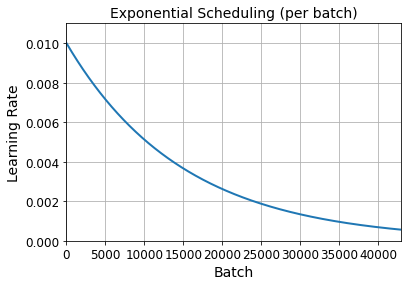

In [56]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise constant scheduling

Set a distinct lr value for a number of steps. Requires some tuning to get the right ranges right. 

In [57]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [58]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5,15], [0.01, 0.005, 0.001])

In [59]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
# changed this to 10 so it'd run faster
n_epochs = 10
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.8318 - accuracy: 0.7584 - val_loss: 1.1263 - val_accuracy: 0.7276
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.8456 - accuracy: 0.7535 - val_loss: 0.7649 - val_accuracy: 0.7598
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 1.0241 - accuracy: 0.6958 - val_loss: 1.5803 - val_accuracy: 0.4586
Epoch 4/10
1719/1719 [==============================] - 11s 7ms/step - loss: 1.2020 - accuracy: 0.6292 - val_loss: 1.0857 - val_accuracy: 0.6400
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 1.1282 - accuracy: 0.5990 - val_loss: 1.7336 - val_accuracy: 0.5272
Epoch 6/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.9051 - accuracy: 0.6478 - val_loss: 0.8755 - val_accuracy: 0.6760
Epoch 7/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.8558 - accuracy: 0.6681 - val_loss: 0.8842 - val_acc

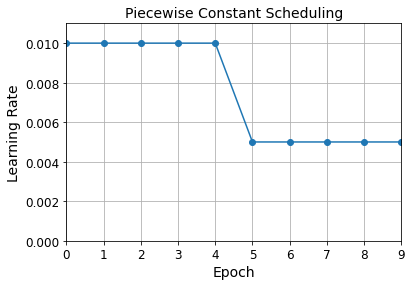

In [60]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0,n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling

Reduces lr when error stops dropping.

In [61]:
tf.random.set_seed(42)
np.random.seed(42)

In [62]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5925 - accuracy: 0.8074 - val_loss: 0.5282 - val_accuracy: 0.8466
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4914 - accuracy: 0.8418 - val_loss: 0.6569 - val_accuracy: 0.8186
Epoch 3/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5135 - accuracy: 0.8419 - val_loss: 0.4895 - val_accuracy: 0.8514
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5122 - accuracy: 0.8467 - val_loss: 0.4845 - val_accuracy: 0.8440
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5168 - accuracy: 0.8493 - val_loss: 0.5630 - val_accuracy: 0.8344
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5005 - accuracy: 0.8548 - val_loss: 0.6042 - val_accuracy: 0.8498
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5188 - accuracy: 0.8538 - val_loss: 0.6452 - val_accuracy:

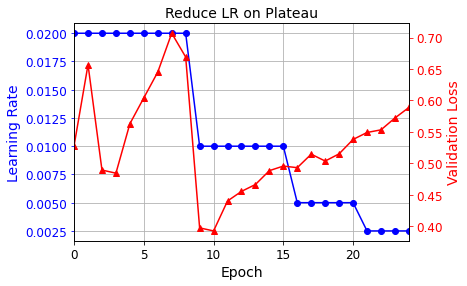

In [65]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras schedulers

it has its own version, no need to write a function for exponential scheduling or piecewise constant, these will update at each step howver.

In [66]:
# Exponential decay scheduling

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4894 - accuracy: 0.8274 - val_loss: 0.4092 - val_accuracy: 0.8604
Epoch 2/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3820 - accuracy: 0.8650 - val_loss: 0.3738 - val_accuracy: 0.8692
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3487 - accuracy: 0.8766 - val_loss: 0.3733 - val_accuracy: 0.8686
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3264 - accuracy: 0.8835 - val_loss: 0.3493 - val_accuracy: 0.8804
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3104 - accuracy: 0.8897 - val_loss: 0.3429 - val_accuracy: 0.8796
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2959 - accuracy: 0.8950 - val_loss: 0.3415 - val_accuracy: 0.8810
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2854 - accuracy: 0.8988 - val_loss: 0.3354 - val_accuracy:

In [67]:
# for piecewise constant scheduling 

learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

### 1Cycle Scheduling

Very good at converging, looks better than both exponential and performance. 

Increases lr linearly to a point then linearly back down, and then drop several orders of magnitude linearly.

## Regularization, avoiding overfitting

Some previous regularizaiton techniques: early stopping, and Batch Normalization


### ℓ1 and ℓ2 regularization

Can use L2 regularization to constrain weights and L1 to get a sparse model.

In [73]:
layer = keras.layers.Dense(100, activation="elu",
                          kernel_initializer = "he_normal",
                          kernel_regularizer = keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [75]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
    
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 13s 7ms/step - loss: 1.5816 - accuracy: 0.8115 - val_loss: 0.7197 - val_accuracy: 0.8302
Epoch 2/2
1719/1719 [==============================] - 12s 7ms/step - loss: 0.7210 - accuracy: 0.8276 - val_loss: 0.6862 - val_accuracy: 0.8360


Some refactoring advice to not have to repeat layers, either use loops or `from functools import partial`

In [76]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                          activation="elu",
                          kernel_initializer="he_normal",
                          kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))


Epoch 1/2
1719/1719 [==============================] - 13s 7ms/step - loss: 1.6630 - accuracy: 0.8122 - val_loss: 0.7201 - val_accuracy: 0.8308
Epoch 2/2
1719/1719 [==============================] - 12s 7ms/step - loss: 0.7188 - accuracy: 0.8266 - val_loss: 0.6806 - val_accuracy: 0.8402


### Dropout

Great regularizer. Simply, every neuron has a chance to be ignored during a training step. Typically set between 10% and 50%: around 20-30% in RNN's and around 40-50% in CNN's.

Their power comes from each neuron can't rely on the others to pick up slack, it has to be as useful as possible. Also, its training on a different neural network every training step, and then ensembles them.

**In practice**, I can only apply dropout to the top one or three layers. 

*Note*: Since dropout is only active during training, looking at the training loss and validation loss can be wrong. It may be overfitting. Make sure to evaluate the training loss without dropout.

`keras.layers.Dropout(rate=0.2)`

#### Alpha dropout

If using SELU activation function, you will need to use alpha dropout because regular dropout will break the self-normalization.

`keras.layers.AlphaDropout(rate=0.2)`

### Monte Carlo (MC) Dropout

Boosting a model that has dropout layer's performance without having to retrain. 

Make a 100(example) predictions on the test set, set `training=True` for the Dropout layer to be active, and then stack the predictions. 

In [77]:
tf.random.set_seed(42)
np.random.seed(42)

In [84]:
y_probas = np.stack([model(X_test_scaled, training=True)
                    for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [82]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.23, 0.  , 0.24, 0.01, 0.5 ]],
      dtype=float32)

In [83]:
#getting weird values here, probably because i skipped
#assigning values for MNIST
np.round(y_probas[:, :1], 2)

array([[[0.04, 0.03, 0.07, 0.04, 0.07, 0.06, 0.07, 0.14, 0.23, 0.24]],

       [[0.04, 0.03, 0.07, 0.04, 0.07, 0.06, 0.07, 0.14, 0.23, 0.24]],

       [[0.04, 0.03, 0.07, 0.04, 0.07, 0.06, 0.07, 0.14, 0.23, 0.24]],

       [[0.04, 0.03, 0.07, 0.04, 0.07, 0.06, 0.07, 0.14, 0.23, 0.24]],

       [[0.04, 0.03, 0.07, 0.04, 0.07, 0.06, 0.07, 0.14, 0.23, 0.24]],

       [[0.04, 0.03, 0.07, 0.04, 0.07, 0.06, 0.07, 0.14, 0.23, 0.24]],

       [[0.04, 0.03, 0.07, 0.04, 0.07, 0.06, 0.07, 0.14, 0.23, 0.24]],

       [[0.04, 0.03, 0.07, 0.04, 0.07, 0.06, 0.07, 0.14, 0.23, 0.24]],

       [[0.04, 0.03, 0.07, 0.04, 0.07, 0.06, 0.07, 0.14, 0.23, 0.24]],

       [[0.04, 0.03, 0.07, 0.04, 0.07, 0.06, 0.07, 0.14, 0.23, 0.24]],

       [[0.04, 0.03, 0.07, 0.04, 0.07, 0.06, 0.07, 0.14, 0.23, 0.24]],

       [[0.04, 0.03, 0.07, 0.04, 0.07, 0.06, 0.07, 0.14, 0.23, 0.24]],

       [[0.04, 0.03, 0.07, 0.04, 0.07, 0.06, 0.07, 0.14, 0.23, 0.24]],

       [[0.04, 0.03, 0.07, 0.04, 0.07, 0.06, 0.07, 0.14, 0.23, 0

If there are other layers like Batch Normalization layers, then I shouldn't force the trainnig mode like above. Should use whats below:

In [90]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])

class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

tf.random.set_seed(42)
np.random.seed(42)

mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [91]:
mc_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 784)               0         
_________________________________________________________________
mc_alpha_dropout (MCAlphaDro (None, 784)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 300)               235500    
_________________________________________________________________
mc_alpha_dropout_1 (MCAlphaD (None, 300)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 100)               30100     
_________________________________________________________________
mc_alpha_dropout_2 (MCAlphaD (None, 100)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 10)              

If I am creating a model from scratch, use the above MCDropout(). If the model already had a regular Dropout layer, then I need to create an identical model that replaces the Dropout layers with MCDropout layers and then copy the model's weights into the new one. 

There is no need to do the above if using the Functional API or Subclassing API, the `training=True` value is right there.

### Max-Norm Regularization

Very much like L2 regularization. Doesn't add a regularization loss term to the overall loss function. Can help with unstable gradients if not using BN.

After each training iteration, the fit() method will look at the object returned by max_norm() and rescale the weights.

`layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",                 kernel_constraint=keras.constraints.max_norm(1.))`

I can define my own custom constraint function and also there is the `bias_constraint` argument.

`max_norm` has a axis argument default to 0. If wanting to use it on convolutional layers, set to [0,1,2]. 


**Default suggested DNN config**

    Kernal_initializer = He initialization
            activation = ELU
        Normalization  = None if shallow,Batch Norm if deep
        Regularization = Early stopping (+L2 reg if needed)
            Optimizer  = Momentum optimization(or RMSProp or Nadam)
    Learning rate schedule = 1cycle
    
**For self-normalizing network of simple dense layer stack**

    Kernal_initializer = LeCun initialization
            activation = SELU
        Normalization  = None
        Regularization = Alpha dropout if needed
            Optimizer  = Momentum optimization(or RMSProp or Nadam)
    Learning rate schedule = 1cycle

## Summary

- Normalize input features
- Reuse other networks
- use unsupervised pretraining if I have lots of unlabeled data
- use pretraining on auxiliary task if I have a lot of data for similar task

- Need a sparse model, use L1 regularization, if it needs to be even more sparse use Tensorflow model Optimization Toolkit (TF-MOT)
- For low latency model,  use fewer layers, fold Batch Norm layers into previous ones, and maybe use fsater activation functions. Or have a sparse model. Can also reduce float precision. Look at TF-MOT
- If building risk-sensitive application or inference latency is not important, use MC Dropout to boost performance and get uncertainty estimates.

Exercises

1. No, you can't use the same initialization because when backprop happens and the gradients move back through the model, they will all change by thesame amount, making the model seem as if its just one node.

2. Yes, it is okay.

3. Performance, its going to self-normalize, 

4. 

5. Slide out of minimums

6. L1 regularization, TF MOT,

7. Dropout doesn't slow down trainig or inference since all it does is not use some neurons in the network . And it wont be active during inferenc either. MC-D(ropout will slow down inference time. 

8.

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


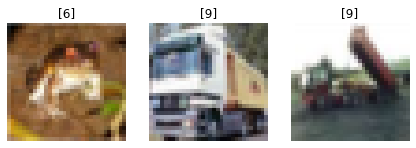

In [16]:
plt.figure(figsize=(7.2,2.4))
for index in range(3):
    plt.subplot(1,3, index+1)
    plt.imshow(X_train_full[index],cmap='binary',interpolation="nearest")
    plt.axis("off")
    plt.title(y_train_full[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [3]:
X_train, X_valid = X_train_full[:5000], X_train_full[5000:]
y_train, y_valid = y_train_full[:5000], y_train_full[5000:]

In [38]:
from functools import partial

AmIDense = partial(keras.layers.Dense, activation="elu",
                                     kernel_initializer="he_normal")

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32,32,3]))
for stacky in range(20):
    model.add(AmIDense(100))
model.add(AmIDense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
             metrics=["accuracy"])

In [40]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [46]:
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [47]:
%python3 --logdir=./my_cifar10_logs --port=6006

UsageError: Line magic function `%python3` not found (But cell magic `%%python3` exists, did you mean that instead?).


In [41]:
history = model.fit(X_train,y_train,epochs=50,
                   validation_data=(X_valid,y_valid),
                   callbacks=[callbacks])

Epoch 1/50
  1/157 [..............................] - ETA: 0s - loss: 1.7377 - accuracy: 0.3438WARNING:tensorflow:From /opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
157/157 [==============================] - 6s 39ms/step - loss: 1.7312 - accuracy: 0.3696 - val_loss: 2.2048 - val_accuracy: 0.2509
Epoch 2/50
157/157 [==============================] - 6s 37ms/step - loss: 1.7422 - accuracy: 0.3560 - val_loss: 2.0375 - val_accuracy: 0.2916
Epoch 3/50
157/157 [==============================] - 5s 34ms/step - loss: 1.7099 - accuracy: 0.3714 - val_loss: 2.0645 - val_accuracy: 0.2780
Epoch 4/50
157/157 [==============================] - 6s 36ms/step - loss: 1.7071 - accuracy: 0.3794 - val_loss: 2.2097 - val_accuracy: 0.2467
Epoch 5/50
157/157 [==========================

In [4]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32,32,3]))
model.add(keras.layers.BatchNormalization())
for stacky in range(20):
    model.add(keras.layers.Dense (100,
                                     kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
             metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_bn_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_bn_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]



In [18]:
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/100
  1/157 [..............................] - ETA: 0s - loss: 2.7292 - accuracy: 0.0312WARNING:tensorflow:From /opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
157/157 [==============================] - 9s 60ms/step - loss: 2.0762 - accuracy: 0.2556 - val_loss: 2.4119 - val_accuracy: 0.2300
Epoch 2/100
157/157 [==============================] - 7s 46ms/step - loss: 1.8715 - accuracy: 0.3182 - val_loss: 1.9393 - val_accuracy: 0.3188
Epoch 3/100
157/157 [==============================] - 7s 43ms/step - loss: 1.7821 - accuracy: 0.3560 - val_loss: 1.9342 - val_accuracy: 0.3285
Epoch 4/100
157/157 [==============================] - 7s 46ms/step - loss: 1.7272 - accuracy: 0.3774 - val_loss: 1.9386 - val_accuracy: 0.3190
Epoch 5/100
157/157 [=====================

The model defintiely got better, converged slightly faster, but it definitely increased the training time. 

In [29]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32,32,3]))

for _ in range(20):
    model.add(keras.layers.Dense(100, activation="selu",
                                kernel_initializer='lecun_normal'))
model.add(keras.layers.Dense(10, activation="softmax" ))

optimizer= keras.optimizers.Nadam(lr=7e-4)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
             metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(patience=20)
callbacks = [early_stopping]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)

X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds


history_selu = model.fit(X_train_scaled, y_train, epochs=100,
                        validation_data= (X_valid_scaled,y_valid),
                        callbacks=callbacks)

Epoch 1/100
157/157 [==============================] - 7s 48ms/step - loss: 2.1695 - accuracy: 0.2374 - val_loss: 2.4625 - val_accuracy: 0.2024
Epoch 2/100
157/157 [==============================] - 5s 35ms/step - loss: 1.9711 - accuracy: 0.2844 - val_loss: 2.1074 - val_accuracy: 0.2585
Epoch 3/100
157/157 [==============================] - 7s 44ms/step - loss: 1.8872 - accuracy: 0.3246 - val_loss: 2.0137 - val_accuracy: 0.2748
Epoch 4/100
157/157 [==============================] - 6s 36ms/step - loss: 1.8220 - accuracy: 0.3436 - val_loss: 1.9960 - val_accuracy: 0.2687
Epoch 5/100
157/157 [==============================] - 5s 32ms/step - loss: 1.7528 - accuracy: 0.3710 - val_loss: 2.0832 - val_accuracy: 0.2764
Epoch 6/100
157/157 [==============================] - 5s 35ms/step - loss: 1.6978 - accuracy: 0.3910 - val_loss: 2.0892 - val_accuracy: 0.2938
Epoch 7/100
157/157 [==============================] - 5s 35ms/step - loss: 1.6386 - accuracy: 0.4194 - val_loss: 2.0954 - val_accuracy:

It does get a little higher validation accuracy for the same ttraining time.

In [30]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32,32,3]))

for _ in range(20):
    model.add(keras.layers.Dense(100, activation="selu",
                                kernel_initializer='lecun_normal'))
model.add(keras.layers.AlphaDropout(rate=0.2))
model.add(keras.layers.Dense(10, activation="softmax" ))

optimizer= keras.optimizers.Nadam(lr=7e-4)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
             metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(patience=20)
callbacks = [early_stopping]


history_selu = model.fit(X_train_scaled, y_train, epochs=100,
                        validation_data= (X_valid_scaled,y_valid),
                        callbacks=callbacks)

Epoch 1/100
157/157 [==============================] - 14s 89ms/step - loss: 2.3033 - accuracy: 0.2072 - val_loss: 2.1654 - val_accuracy: 0.2624
Epoch 2/100
157/157 [==============================] - 6s 36ms/step - loss: 1.9630 - accuracy: 0.2916 - val_loss: 2.2955 - val_accuracy: 0.2335
Epoch 3/100
157/157 [==============================] - 5s 33ms/step - loss: 1.8768 - accuracy: 0.3160 - val_loss: 2.0165 - val_accuracy: 0.2932
Epoch 4/100
157/157 [==============================] - 5s 31ms/step - loss: 1.8037 - accuracy: 0.3520 - val_loss: 1.9958 - val_accuracy: 0.3269
Epoch 5/100
157/157 [==============================] - 5s 33ms/step - loss: 1.7389 - accuracy: 0.3810 - val_loss: 2.1376 - val_accuracy: 0.3348
Epoch 6/100
157/157 [==============================] - 5s 35ms/step - loss: 1.6787 - accuracy: 0.4040 - val_loss: 2.0358 - val_accuracy: 0.3370
Epoch 7/100
157/157 [==============================] - 5s 34ms/step - loss: 1.6118 - accuracy: 0.4300 - val_loss: 2.0469 - val_accuracy

Not much better than the other models.

In [31]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

tf.random.set_seed(42)
np.random.seed(42)

mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])


In [32]:
mc_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               307300    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)              

In [33]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9,
                                nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", 
                 optimizer=optimizer, metrics=["accuracy"])

In [34]:
mc_model.set_weights(model.get_weights())

In [36]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.32, 0.  , 0.65, 0.03, 0.  , 0.  , 0.  ]],
      dtype=float32)

In [37]:

def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = np.mean(y_pred == y_valid[:, 0])
accuracy

0.37662222222222225

No improvement either